Some basic examples on how to use the Mechanical Turk Tracker Demographics API:

### Demographics API

Below we have the code that retrieves the data from the  Mechanical Turk Tracker Demographics API.

In [1]:
from datetime import datetime
import time

# This function takes as input the response for a single survey, and transforms it into a flat dictionary
def flatten(item):
    fmt = "%Y-%m-%dT%H:%M:%S.%fZ"
    
    hit_answer_date = datetime.strptime(item["date"], fmt)
    hit_creation_str = item.get("hitCreationDate")
    
    if hit_creation_str is None: 
        hit_creation_date = None 
        diff = None
    else:
        hit_creation_date = datetime.strptime(hit_creation_str, fmt)
        # convert to unix timestamp
        hit_date_ts = time.mktime(hit_creation_date.timetuple())
        answer_date_ts = time.mktime(hit_answer_date.timetuple())
        diff = int(answer_date_ts-hit_date_ts)
    
    result = {
        "worker_id": str(item["workerId"]),
        "gender": str(item["answers"]["gender"]),
        "household_income": str(item["answers"]["householdIncome"]),
        "household_size": str(item["answers"]["householdSize"]),
        "marital_status": str(item["answers"].get("maritalStatus")),
        "year_of_birth": int(item["answers"]["yearOfBirth"]),
        "location_city": str(item.get("locationCity")),
        "location_region": str(item.get("locationRegion")),
        "location_country": str(item["locationCountry"]),
        "hit_answered_date": hit_answer_date,
        "hit_creation_date": hit_creation_date,
        "post_to_completion_secs": diff
    }
    return result

In [2]:
# The code below retrieves all the responses from the Demographics API
# Since we cannot get all the responses at once, we fetch a few thousand
# records at a time, until fetching them all

import requests
import json

limit = 5000

# The API call that returns the last survey responses
baseurl = "https://mturk-surveys.appspot.com/" + \
    "_ah/api/survey/v1/survey/demographics/answers?limit=" + str(limit)

# This is the cursor variable, used to retrieve more pages of results
nextPageToken = None

# We store the results in this list
results = []

while True:
    if nextPageToken == None:
        url = baseurl
    else:
        url = baseurl + "&cursor=" + nextPageToken

    resp = requests.get(url)
    if resp.status_code == 200:
        data = json.loads(resp.text)
        items = data.get("items")
        if items == None:
            break
        print "Retrieved ", len(items), " responses"
        responses = [flatten(item) for item in items]
        results.extend(responses)
        print "Total of ", len(results), " responses in our data"
    else:
        print "Something went wrong with the network call"

    nextPageToken = data.get("nextPageToken")
    if nextPageToken == None:
        break


Retrieved  5000  responses
Total of  5000  responses in our data
Retrieved  5000  responses
Total of  10000  responses in our data
Retrieved  5000  responses
Total of  15000  responses in our data
Retrieved  5000  responses
Total of  20000  responses in our data
Retrieved  5000  responses
Total of  25000  responses in our data
Retrieved  5000  responses
Total of  30000  responses in our data
Retrieved  5000  responses
Total of  35000  responses in our data
Retrieved  5000  responses
Total of  40000  responses in our data
Retrieved  5000  responses
Total of  45000  responses in our data
Retrieved  3059  responses
Total of  48059  responses in our data


In [3]:
# Let's print the total number of retrieved responses
print len(results)

48059


In [4]:
import pandas as pd
df = pd.DataFrame(results)
# Let's save the file as a CSV
df.to_csv("mturk_surveys.csv")

In [5]:
# df = pd.read_csv("mturk_surveys.csv")

In [6]:
df.dtypes

gender                             object
hit_answered_date          datetime64[ns]
hit_creation_date          datetime64[ns]
household_income                   object
household_size                     object
location_city                      object
location_country                   object
location_region                    object
marital_status                     object
post_to_completion_secs           float64
worker_id                          object
year_of_birth                       int64
dtype: object

In [7]:
import pandas as pd

# We now transform our API answer into a flat table
# and set the right data types
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = map(lambda x : x.date(), df['hit_answered_date'])
df['time'] = map(lambda x : x.time(), df['hit_answered_date'])
df.dtypes

gender                             object
hit_answered_date          datetime64[ns]
hit_creation_date          datetime64[ns]
household_income                 category
household_size                   category
location_city                      object
location_country                 category
location_region                    object
marital_status                   category
post_to_completion_secs           float64
worker_id                          object
year_of_birth                       int64
date                               object
time                               object
dtype: object

In [8]:
import datetime
minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])
days = (maxDate - minDate).days
print minDate
print maxDate
print days

2015-03-26 11:47:28.877000
2016-06-30 16:32:21.931000
462


In [9]:
df.head(5)

,gender,hit_answered_date,hit_creation_date,household_income,household_size,location_city,location_country,location_region,marital_status,post_to_completion_secs,worker_id,year_of_birth,date,time
0,female,2016-06-30 16:32:21.931,2016-06-30 16:01:11,"$15,000-$24,999",3,johnson city,US,tn,married,1870.0,e32a93e2b2ca201229d1ce9bf5f1e690,1971,2016-06-30,16:32:21.931000
1,male,2016-06-30 15:47:54.105,2016-06-30 15:46:10,"$10,000-$14,999",3,kolkata,IN,wb,single,104.0,4d95deb58b53b833a19e67eb45ab1bef,1995,2016-06-30,15:47:54.105000
2,female,2016-06-30 15:33:58.699,2016-06-30 15:31:12,"$100,000 or more",3,gainesville,US,va,married,166.0,e957176f654eba122eb3f8b5de2aceac,1956,2016-06-30,15:33:58.699000
3,female,2016-06-30 15:25:40.968,2016-06-30 15:16:10,"$25,000-$39,999",2,columbia,US,mo,single,570.0,744f8396e65938713d1889374f8e120f,1965,2016-06-30,15:25:40.968000
4,female,2016-06-30 15:11:41.654,2016-06-30 15:01:11,"$75,000-$99,999",2,chicago,US,il,engaged,630.0,7d3825d727f090a48ae937db8a19ef54,1986,2016-06-30,15:11:41.654000


### Exploratory plots

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
mpl.rc("figure", figsize=(16, 8))

#### Countries of the workers

In [11]:
# Let's see the top countries
country = df['location_country'].value_counts() / len(df)

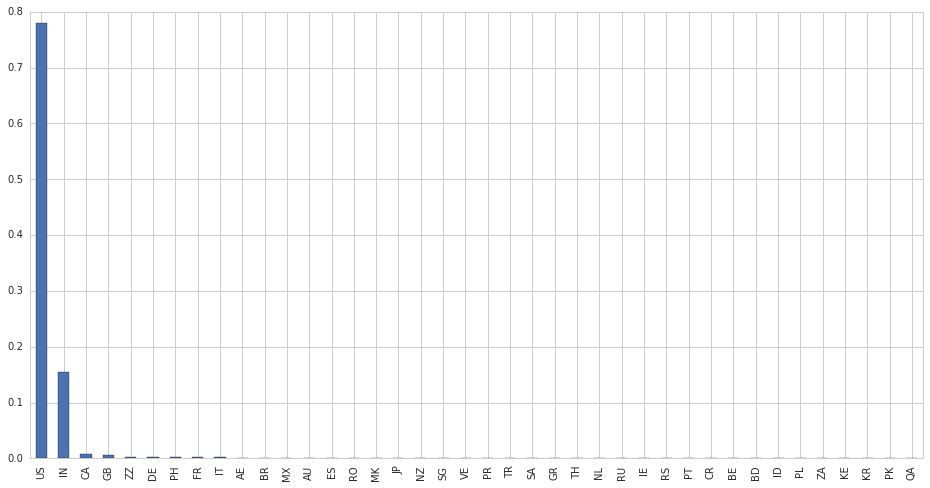

In [12]:
country.head(40).plot.bar(logy=False)

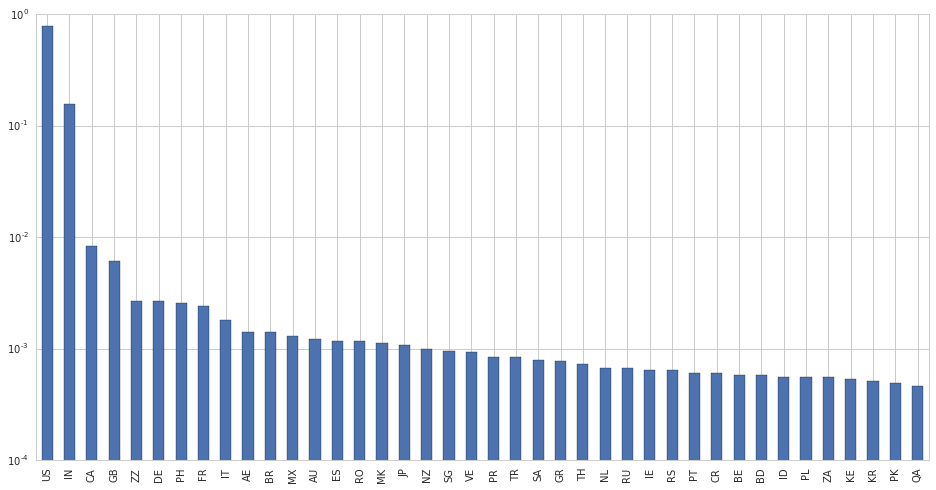

In [13]:
country.head(40).plot.bar(logy=True)

In [14]:
import numpy as np

country_table = pd.crosstab(index=df.date, columns=df.location_country, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')


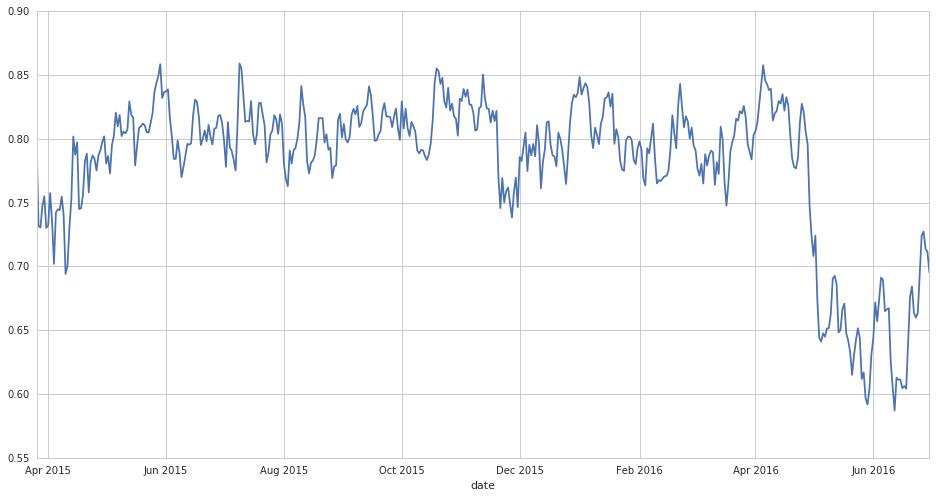

In [15]:
country_table['US'].ewm(span=7).mean().plot()

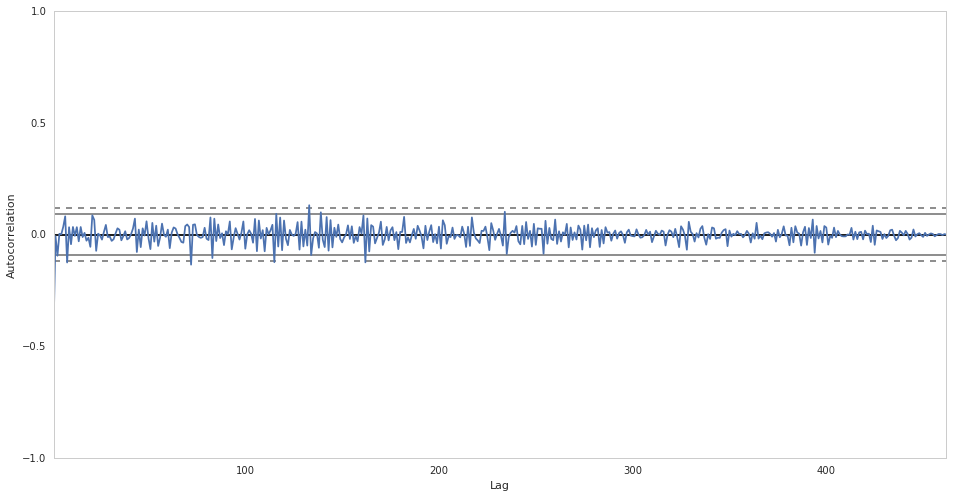

In [16]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(country_table['US'].diff()[1:])

### Capture Recapture model

We will now attempt to estimate the capture-recapture models in order to estimate the overall population size of MTurk workers.


We will start with the simplest models first, expanding to more complex approaches later:

The underlying assumptions:

1. Constant population over the two samples (i.e., no workers arrive or depart from the platform)
2. The workerID corresponds to a single worker (i.e., no sharing of accounts) and each worker has a single workerID.
3. All workers have the same propensity of participating in the survey.

#### Two-occasion Model (Lincoln Estimator)

This model assumes that we have two samples (the "capture" and the "recapture"). In our data set we have significiantly more data, which allows for more expressive and powerful models, but we will start with the simplest model first, to illustrate the approach.

In the first sample we "capture" (survey) $n_1$ workers out of the $N$ workers in the population. (We know $n_1$ but not $N$.) In the second sample we "recapture" $n_2$ workers out of the same population of $N$ workers, and we observe a set of $m$ workers both in the "capture" and "recapture" samples. Following a multinomial model with a maximum likelihood estimator, every time that we pick a worker in the second sample, the probability of the worker being the first sample is $n_1 / N$, so the total number of common workers in a sample of $n_2$ workers will be $m = \frac{n_1 \cdot n_2}{N}$. So, given that we know $m$, $n_1$ and $n_2$, we get our estimate for $N$ to be  $N = \frac{n_1 \cdot n_2}{m}$.

In [17]:
def getWorkerIDs(df, startDate, endDate):
    '''
    Returns the set of distinct workers that participated in the surveys between the two dates
    '''
    return set(df["worker_id"][(df['hit_answered_date']>=startDate) & (df['hit_answered_date']<endDate)])


In [18]:
def capture_recapture_lincoln_estimator(df, groupAstart, groupBstart, window):
    groupAend = groupAstart + datetime.timedelta(days=window)
    groupBend = groupBstart + datetime.timedelta(days=window)
    workersA = getWorkerIDs(df, groupAstart, groupAend)
    workersB = getWorkerIDs(df, groupBstart, groupBend)
    union = workersA | workersB
    intersection = workersA & workersB
    if len(intersection) > 0:
        capture_recapture_estimate = len(workersA) * len(workersB) / len(intersection)
    else:
        capture_recapture_estimate = None

    return {
        "window" : window,
        "groupA_start" : groupAstart,
        "groupA_end" : groupAend,
        "groupB_start" : groupBstart,
        "groupB_end" : groupBend,
        "date_diff": (groupBstart - groupAstart).days,
        "workers_A" : len(workersA),
        "workers_B" : len(workersB),
        "workers_union" : len(union),
        "workers_intersection": len(intersection),
        "capture_recapture_estimate": capture_recapture_estimate
    }


Let's try our estimate for the first and third months in the data set:

In [19]:
window = 30
offset = 0
date_diff = 60
first_date = minDate + datetime.timedelta(days=offset)
second_date = first_date + datetime.timedelta(days=date_diff)
capture_recapture_lincoln_estimator(df, first_date, second_date, window)

{'capture_recapture_estimate': 13410,
 'date_diff': 60,
 'groupA_end': Timestamp('2015-04-25 11:47:28.877000'),
 'groupA_start': Timestamp('2015-03-26 11:47:28.877000'),
 'groupB_end': Timestamp('2015-06-24 11:47:28.877000'),
 'groupB_start': Timestamp('2015-05-25 11:47:28.877000'),
 'window': 30,
 'workers_A': 2812,
 'workers_B': 2828,
 'workers_intersection': 593,
 'workers_union': 5047}

And try again for the 6th month and the 7th month in the data set

In [20]:
window = 30
offset = 180
date_diff = 30
first_date = minDate + datetime.timedelta(days=offset)
second_date = first_date + datetime.timedelta(days=date_diff)
capture_recapture_lincoln_estimator(df, first_date, second_date, window)

{'capture_recapture_estimate': 14747,
 'date_diff': 30,
 'groupA_end': Timestamp('2015-10-22 11:47:28.877000'),
 'groupA_start': Timestamp('2015-09-22 11:47:28.877000'),
 'groupB_end': Timestamp('2015-11-21 11:47:28.877000'),
 'groupB_start': Timestamp('2015-10-22 11:47:28.877000'),
 'window': 30,
 'workers_A': 2877,
 'workers_B': 2845,
 'workers_intersection': 555,
 'workers_union': 5167}

Now, we are going to try various pairs of dates (all for the same window of 30 days worth of sampling). 

In [21]:
import random

sample_size_dates = 200
sample_dates = random.sample(df['date'], sample_size_dates)

#sample_size_windows = 10
#sample_window = random.sample(range(days), sample_size_windows)
sample_window = [30]

result = []
for groupAstart in sample_dates:
    for groupBstart in sample_dates:
        for window in sample_window:
            if groupBstart > groupAstart + datetime.timedelta(days=window) + datetime.timedelta(days=30) and groupBstart + datetime.timedelta(days=window) < maxDate.date():
                    r = capture_recapture_lincoln_estimator(df,groupAstart, groupBstart, window)
                    result.append(r)



In [22]:
lincoln_estimates = pd.DataFrame(result)
lincoln_estimates.head(5)


,capture_recapture_estimate,date_diff,groupA_end,groupA_start,groupB_end,groupB_start,window,workers_A,workers_B,workers_intersection,workers_union
0,19862,230,2015-09-29,2015-08-30,2016-05-16,2016-04-16,30,2873,2876,416,5333
1,20952,237,2015-09-29,2015-08-30,2016-05-23,2016-04-23,30,2873,2888,396,5365
2,16938,209,2015-09-29,2015-08-30,2016-04-25,2016-03-26,30,2873,2883,489,5267
3,23809,258,2015-09-29,2015-08-30,2016-06-13,2016-05-14,30,2873,2884,348,5409
4,16977,197,2015-09-29,2015-08-30,2016-04-13,2016-03-14,30,2873,2872,486,5259


Now, let's see our estimated values:

In [23]:
print np.mean(lincoln_estimates[['capture_recapture_estimate']])
print np.median(lincoln_estimates[['capture_recapture_estimate']])
print np.std(lincoln_estimates[['capture_recapture_estimate']])

capture_recapture_estimate    18024.29299
dtype: float64
17201.0
capture_recapture_estimate    3928.258464
dtype: float64


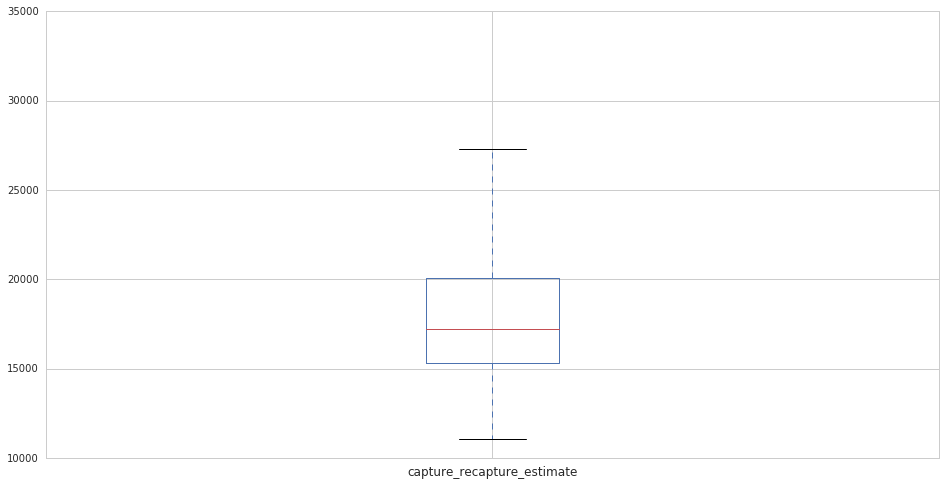

In [24]:
lincoln_estimates[['capture_recapture_estimate']].boxplot(figsize=(15,10), return_type='axes')

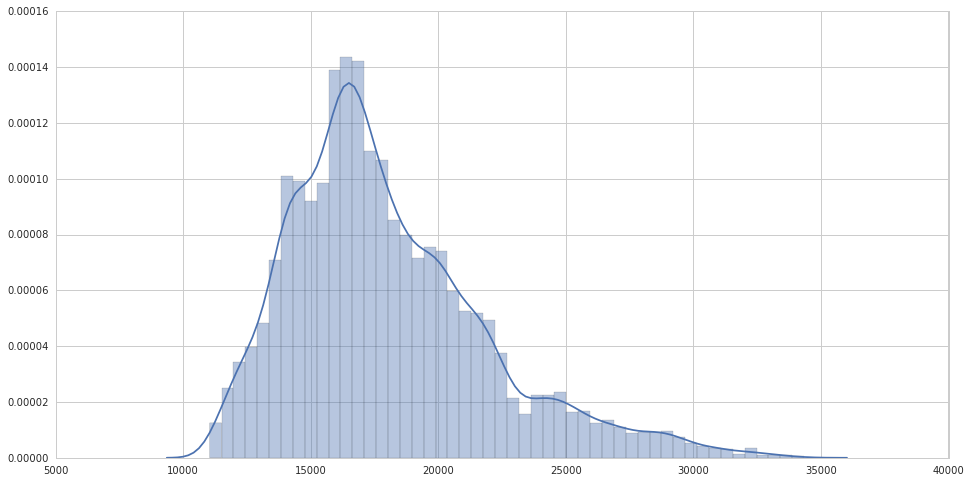

In [25]:
import seaborn as sns
sns.distplot(lincoln_estimates[['capture_recapture_estimate']]);

### The Schnabel estimator

We implement the Schnabel estimator following the guidelines at # http://www.esf.edu/efb/limburg/Fisheries/Assess_II_Pop/Pop_assessments_IIB.pdf

The Schnabel estimator uses multiple-census procedures:
you collect fish multiple times from your ecosystem, and
each time you collect, you note the number captured, the
number already marked (cumulatively), and you mark all
the new captures that weren’t already marked.

In [26]:
# Helper function
def getAllWorkerIDs(df, startDate, endDate):
    '''
    Returns all the ids of the workers that participated in the surveys between the two dates
    '''
    return list(df["worker_id"][(df['hit_answered_date']>=startDate) & (df['hit_answered_date']<endDate)])


In [27]:
# We will consider a period of "window" days as one catching period.
window = 30
dates = set(df['date'])

min_date = min(dates)
max_date = max(dates)

data = []
startDate = min_date
while startDate < max_date:
    endDate = startDate + datetime.timedelta(days=window)
    period_captured = getWorkerIDs(df, startDate, endDate)
    before_captured = getWorkerIDs(df, min_date, startDate)
    period_recaptured = len(period_captured & before_captured)
    period_unmarked = len(period_captured) - period_recaptured
    data.append( {"period_captured": len(period_captured), 
                  "period_recaptured": period_recaptured,
                  "period_unmarked": period_unmarked,
                  "before_captured": len(before_captured),
                  "startDate": startDate,
                 } 
               )
    startDate = endDate
    
schnabel = pd.DataFrame(data)
schnabel.set_index(keys='startDate', inplace=True)
schnabel.sort_index(inplace=True)


schnabel['total_recaptured'] = schnabel['period_recaptured'].cumsum()
schnabel['CxM'] = schnabel['before_captured'] * schnabel['period_captured']
schnabel['cum_CxM'] = schnabel['CxM'].cumsum()
schnabel['N_estimate'] = schnabel['cum_CxM'] / schnabel['total_recaptured']

schnabel

,before_captured,period_captured,period_recaptured,period_unmarked,total_recaptured,CxM,cum_CxM,N_estimate
startDate,,,,,,,,
2015-03-26,0,2768,0,2768,0,0,0,NaN
2015-04-25,2768,2875,522,2353,522,7958000,7958000,15245.210728
2015-05-25,5121,2830,804,2026,1326,14492430,22450430,16930.942685
2015-06-24,7147,2681,943,1738,2269,19161107,41611537,18339.152490
2015-07-24,8885,2860,1134,1726,3403,25411100,67022637,19695.162210
2015-08-23,10611,2881,1220,1661,4623,30570291,97592928,21110.302401
2015-09-22,12272,2871,1400,1471,6023,35232912,132825840,22053.103105
2015-10-22,13743,2844,1408,1436,7431,39085092,171910932,23134.293096
2015-11-21,15179,2890,1519,1371,8950,43867310,215778242,24109.300782


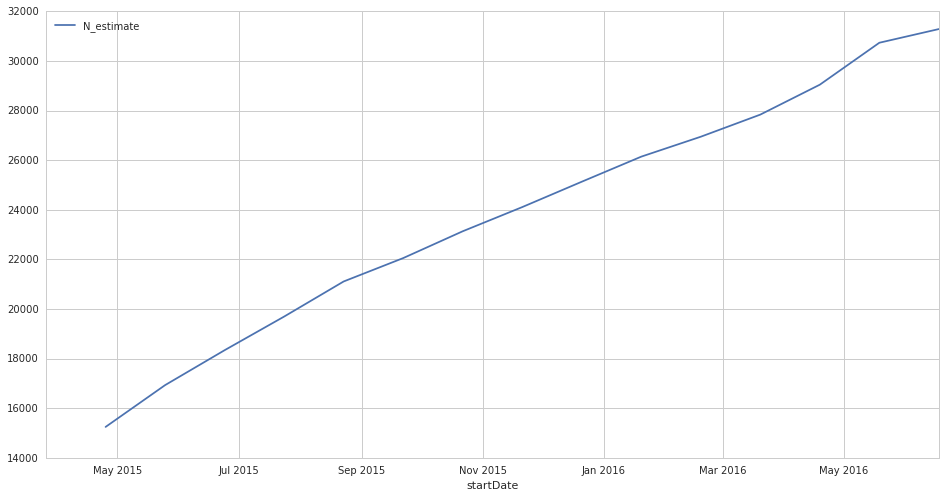

In [28]:
schnabel[['N_estimate']].plot()

We observe a strange trend. Our estimate of the worker population increases with the number of catching periods, instead of converging with the arrival of more data. 

This would be a direct violation of the underlying assumption of both models, which assume that the population is "closed". As we can see below, the same problem exists with the Lincoln estimator, as we can see below.

### Problems with the closed population assumption

In [29]:
# Just for bookkeeping convert the variables to correct data types
lincoln_estimates['groupA_start'] = pd.to_datetime(lincoln_estimates['groupA_start'])
lincoln_estimates['groupA_end'] = pd.to_datetime(lincoln_estimates['groupA_end'])
lincoln_estimates['groupB_start'] = pd.to_datetime(lincoln_estimates['groupB_start'])
lincoln_estimates['groupB_end'] = pd.to_datetime(lincoln_estimates['groupB_end'])

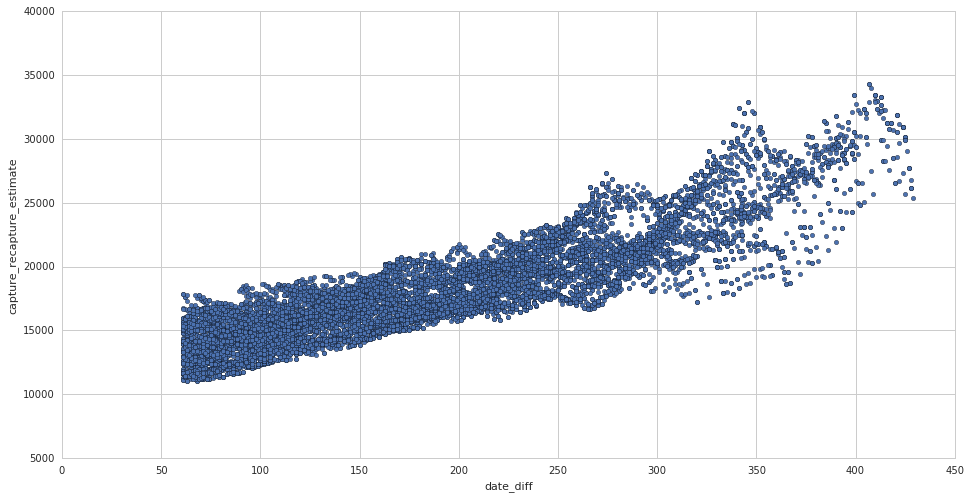

In [30]:
lincoln_estimates.plot.scatter(x='date_diff', y='capture_recapture_estimate')

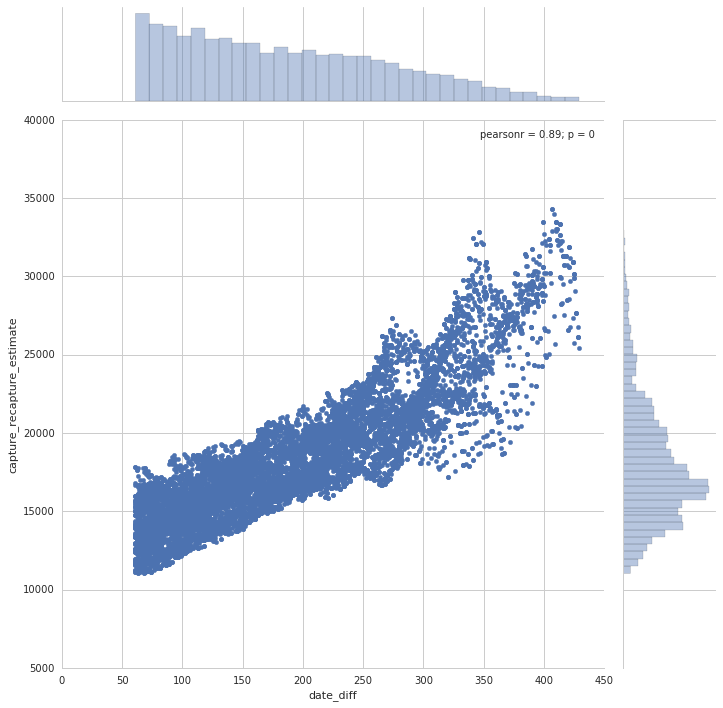

In [31]:
sns.jointplot(x='date_diff', y='capture_recapture_estimate', data=lincoln_estimates, size=10);

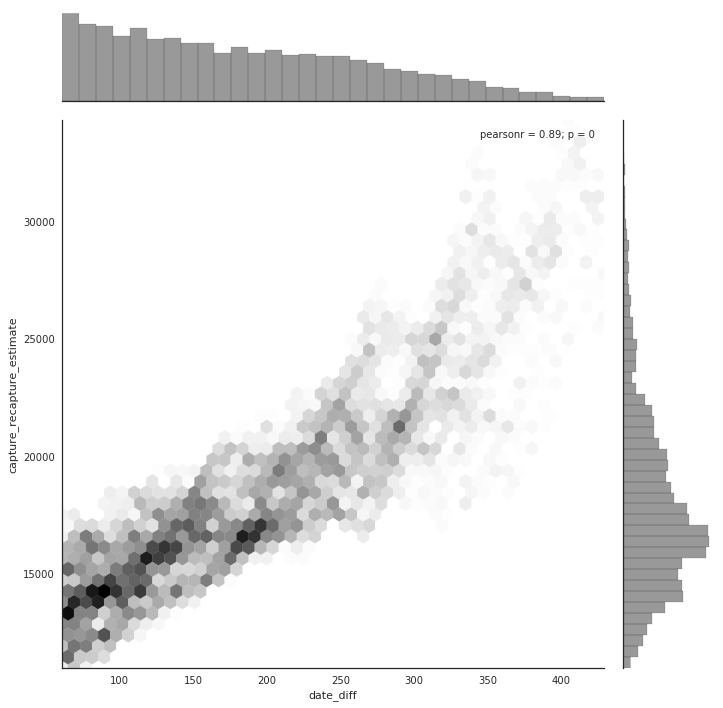

In [32]:
with sns.axes_style("white"):
    sns.jointplot(x='date_diff', y='capture_recapture_estimate', data=lincoln_estimates, kind="hex", color = 'k', size=10);

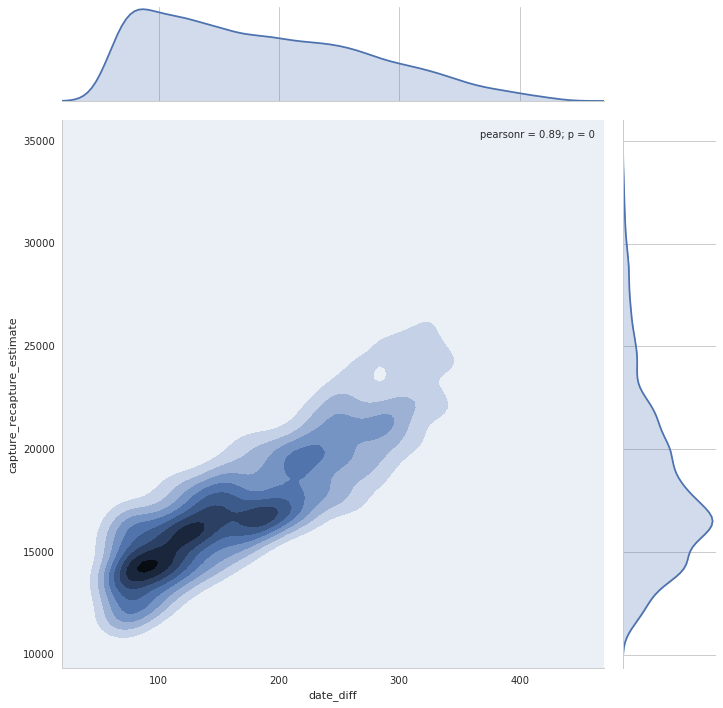

In [33]:
sns.jointplot(x='date_diff', y='capture_recapture_estimate', data=lincoln_estimates, kind="kde", size=10);

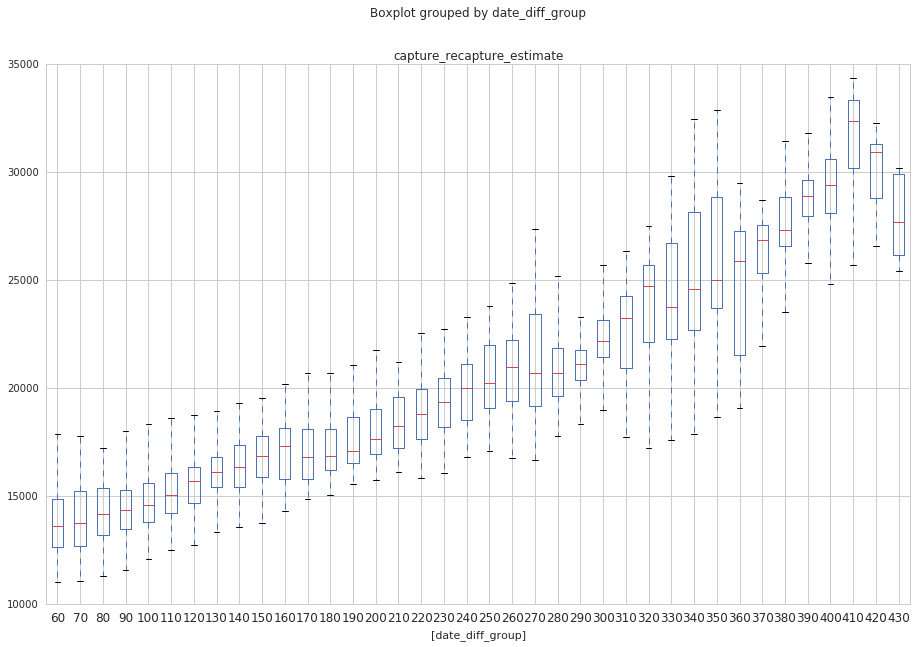

In [34]:
# Let's plot the same plot as above but using box plots, with the date_diff grouped in groups of 10 days
lincoln_estimates['date_diff_group'] = map(lambda x : int(round(x , -1)), lincoln_estimates['date_diff'])
lincoln_estimates[['date_diff_group','capture_recapture_estimate']].boxplot(by='date_diff_group', figsize=(15,10))

Our results indicate that the population estimates are increasing as the difference in dates between datasets increases. This is not normal behavior under the ``closed world'' assumption of the Lincoln estimator, indicating that the assumptions of the model are violated. As we will see below, the key problem is the fact that new workers arrive (are "born"), and old workers quit ("die"). Furhtermore, as we have seen earlier, we see that Amazon opened the registration for non-US workers, allowing "immigration" into our area.

### Allowing for arrival and departure of workers from the population

In [35]:
# We will consider a period of "window" days as one catching period.
window = 14
dates = set(df['date'])

min_date = min(dates)
max_date = max(dates)

data = {}
worker_ids = {}
startDate = min_date
period = 0
while startDate < max_date:
    endDate = startDate + datetime.timedelta(days=window)
    period_captured_ids = getWorkerIDs(df, startDate, endDate)
    worker_ids[period] = period_captured_ids
    
    before_captured_ids = getWorkerIDs(df, min_date, startDate)
    after_captured_ids = getWorkerIDs(df, endDate, max_date)
    before_captured = len(before_captured_ids)
    period_marked = len(period_captured_ids & before_captured_ids)
    period_unmarked = len(period_captured_ids) - period_marked
    period_total = len(period_captured_ids)
    
    period_ids_captured_later = len(period_captured_ids & after_captured_ids)
    before_captured_ids_captured_later = len(before_captured_ids & after_captured_ids)
    
    period_survival = 1.0*period_ids_captured_later / period_total
    if before_captured>0:
        before_survival = 1.0*before_captured_ids_captured_later / before_captured
    else:
        before_survival = -1

    if before_survival>0:
        ratio = period_survival / before_survival
    else:
        ratio = -1

 
    data[period] = {"period_id": period,
                  "before_captured": before_captured,
                  "period_captured": period_total, 
                  "period_marked": period_marked,
                  "period_unmarked": period_unmarked,
                  "startDate": startDate,
                    "endDate": endDate
                 } 

    startDate = endDate
    period += 1

jollyseber = pd.DataFrame(data)
jollyseber.T

,before_captured,endDate,period_captured,period_id,period_marked,period_unmarked,startDate
0,0,2015-04-09,1255,0,0,1255,2015-03-26
1,1255,2015-04-23,1326,1,0,1326,2015-04-09
2,2581,2015-05-07,1336,2,159,1177,2015-04-23
3,3758,2015-05-21,1343,3,288,1055,2015-05-07
4,4813,2015-06-04,1297,4,313,984,2015-05-21
5,5797,2015-06-18,1344,5,416,928,2015-06-04
6,6725,2015-07-02,1338,6,386,952,2015-06-18
7,7677,2015-07-16,1151,7,423,728,2015-07-02
8,8405,2015-07-30,1337,8,503,834,2015-07-16
9,9239,2015-08-13,1338,9,532,806,2015-07-30


In [36]:
survival_probs = []
for period_from in worker_ids.keys():
    period_from_ids = worker_ids.get(period_from)
    for period_to in worker_ids.keys():
        date_diff = (data[period_to]['startDate'] - data[period_from]['startDate']).days
        if date_diff<=0:
            continue
        buffr = (data[period_to]['startDate'] - data[period_from]['endDate']).days
        if buffr < 30:
            continue
        period_to_ids = worker_ids.get(period_to)
        intersection = period_from_ids & period_to_ids
        survival_likelihood = 1.0*len(intersection) / len(period_from_ids)
        survival_probs.append( { "diff":date_diff, "survival": survival_likelihood} )
        
survival_df = pd.DataFrame(survival_probs)


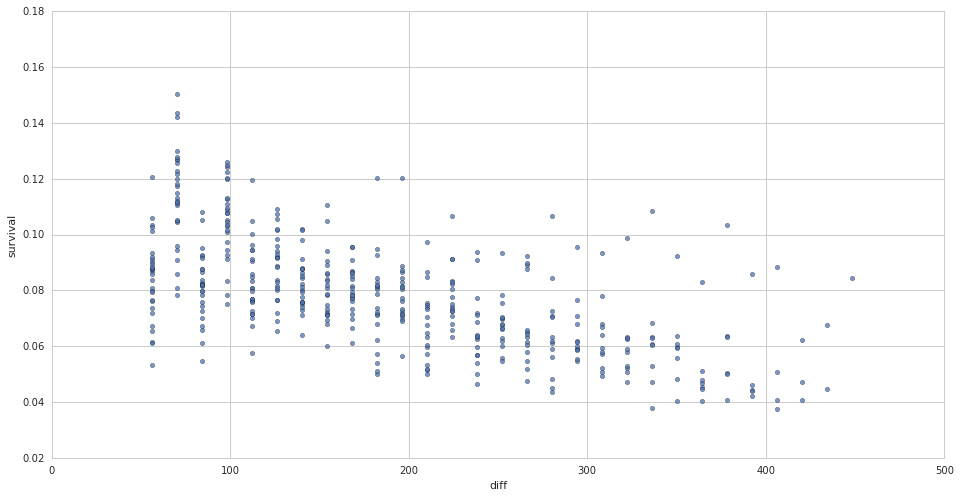

In [37]:
survival_df.plot.scatter(x='diff', y='survival', alpha=0.75)

In [38]:
#survival_df['diff'] = map(lambda x : int(round(x , -1)), survival_df['diff'])
#survival_df = survival_df[survival_df['diff']>30]
#survival_table = survival_df.groupby(by='diff').median()
#surv_diffs = -survival_table.diff().shift(-1)
#1 - surv_diffs / survival_table


In [39]:
# np.median((1 - surv_diffs / survival_table)[:-1])

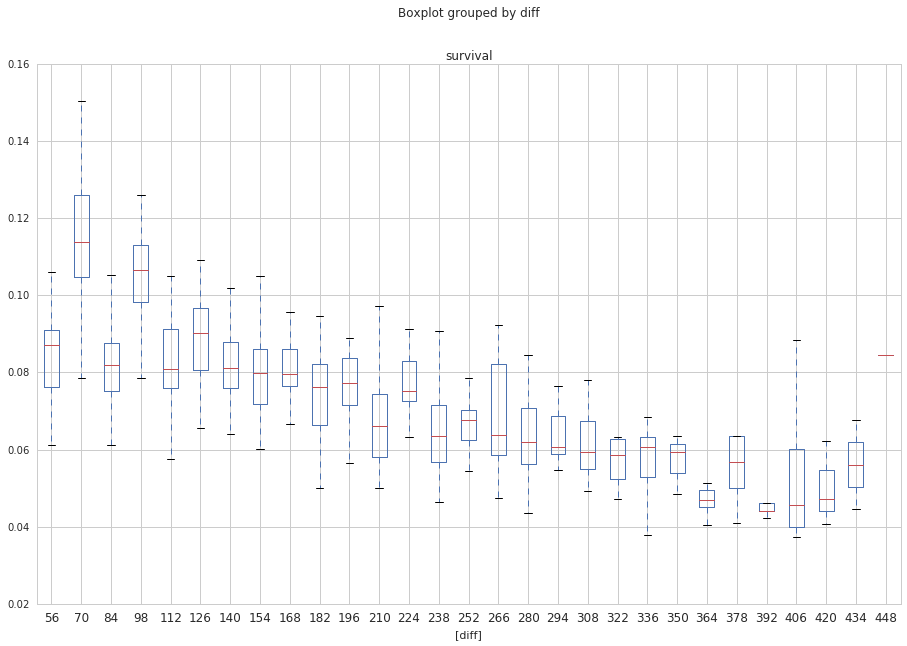

In [40]:
survival_df[['diff','survival']].boxplot(by='diff', figsize=(15,10))

Hence, we can model our current survival function as 

$S(t) = K \cdot \exp(-\lambda \cdot t)$

wotj $K$ being the expected intersection value when we run contemporaneous surveys, and $\lambda$ being the decay rate.



In [41]:
# Assuming an exponential survival function S(t) = K * exp(-lambda * t)
import math
import statsmodels.formula.api as sm
survival_df['logsurvival'] = map(lambda x : math.log(x), survival_df['survival'])
result = sm.ols(formula="logsurvival ~ diff", data=survival_df).fit()
print result.params

Intercept   -2.249398
diff        -0.001741
dtype: float64


In [42]:
fit_K = math.exp(result.params['Intercept'])
fit_l = -result.params['diff']

print "K =", fit_K
print "labda =", fit_l
print "Half-life =", math.log(2)/fit_l

K = 0.105462681525
labda = 0.00174092348322
Half-life = 398.149135928


In [43]:
def survival(t, l = fit_l):
    return np.exp(-fit_l*t)

In [44]:
def capture_recapture_with_survival(df, groupAstart, groupBstart, window):
    
    groupAend = groupAstart + datetime.timedelta(days=window)
    groupBend = groupBstart + datetime.timedelta(days=window)
    diff_days = (groupBstart - groupAstart).days
    workersA = getWorkerIDs(df, groupAstart, groupAend)
    workersB = getWorkerIDs(df, groupBstart, groupBend)
    union = workersA | workersB
    intersection = workersA & workersB
    if len(intersection) > 0:
        capture_recapture_estimate = len(workersA) * len(workersB) * survival(diff_days)  / len(intersection)
    else:
        capture_recapture_estimate = None

    return {
        "window" : window,
        "groupA_start" : groupAstart,
        "groupA_end" : groupAend,
        "groupB_start" : groupBstart,
        "groupB_end" : groupBend,
        "date_diff": diff_days,
        "workers_A" : len(workersA),
        "workers_B" : len(workersB),
        "workers_union" : len(union),
        "workers_intersection": len(intersection),
        "capture_recapture_estimate": capture_recapture_estimate
    }


import random

#sample_size_dates = 200
#sample_dates = random.sample(df['date'], sample_size_dates)
sample_dates = set(df['date'])

#sample_size_windows = 10
#sample_window = random.sample(range(days), sample_size_windows)
sample_window = [30]

result = []
for groupAstart in sample_dates:
    for groupBstart in sample_dates:
        for window in sample_window:
            if groupBstart > groupAstart + datetime.timedelta(days=window) + datetime.timedelta(days=30) and groupBstart + datetime.timedelta(days=window) < maxDate.date():
                    r = capture_recapture_with_survival(df,groupAstart, groupBstart, window)
                    result.append(r)



In [45]:
crs_estimates = pd.DataFrame(result)
crs_estimates.head(5)

,capture_recapture_estimate,date_diff,groupA_end,groupA_start,groupB_end,groupB_start,window,workers_A,workers_B,workers_intersection,workers_union
0,12437.654293,75,2015-08-25,2015-07-26,2015-11-08,2015-10-09,30,2866,2878,582,5162
1,13858.719128,286,2015-08-25,2015-07-26,2016-06-06,2016-05-07,30,2866,2880,362,5384
2,12812.894632,112,2015-08-25,2015-07-26,2015-12-15,2015-11-15,30,2866,2885,531,5220
3,12674.604890,270,2015-08-25,2015-07-26,2016-05-21,2016-04-21,30,2866,2880,407,5339
4,12306.091650,189,2015-08-25,2015-07-26,2016-03-01,2016-01-31,30,2866,2876,482,5260


In [46]:
len(crs_estimates)

69006

In [47]:
print np.mean(crs_estimates[['capture_recapture_estimate']])
print np.median(crs_estimates[['capture_recapture_estimate']])
print np.std(crs_estimates[['capture_recapture_estimate']])

capture_recapture_estimate    12889.07971
dtype: float64
12811.3849868
capture_recapture_estimate    1297.190936
dtype: float64


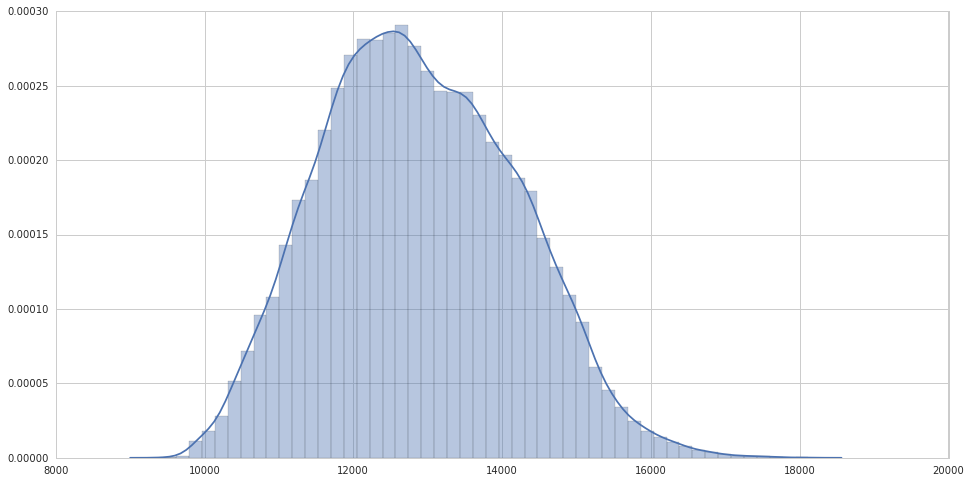

In [48]:
import seaborn as sns
sns.distplot(crs_estimates[['capture_recapture_estimate']]);

In [49]:
# Just for bookkeeping convert the variables to correct data types
crs_estimates['groupA_start'] = pd.to_datetime(crs_estimates['groupA_start'])
crs_estimates['groupA_end'] = pd.to_datetime(crs_estimates['groupA_end'])
crs_estimates['groupB_start'] = pd.to_datetime(crs_estimates['groupB_start'])
crs_estimates['groupB_end'] = pd.to_datetime(crs_estimates['groupB_end'])

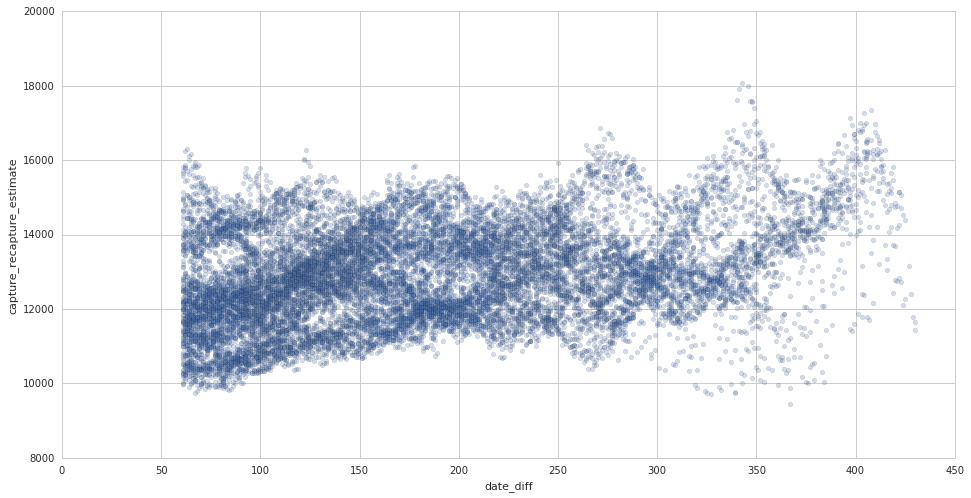

In [50]:
crs_estimates.sample(frac=0.25).plot.scatter(x='date_diff', y='capture_recapture_estimate', alpha=0.25)

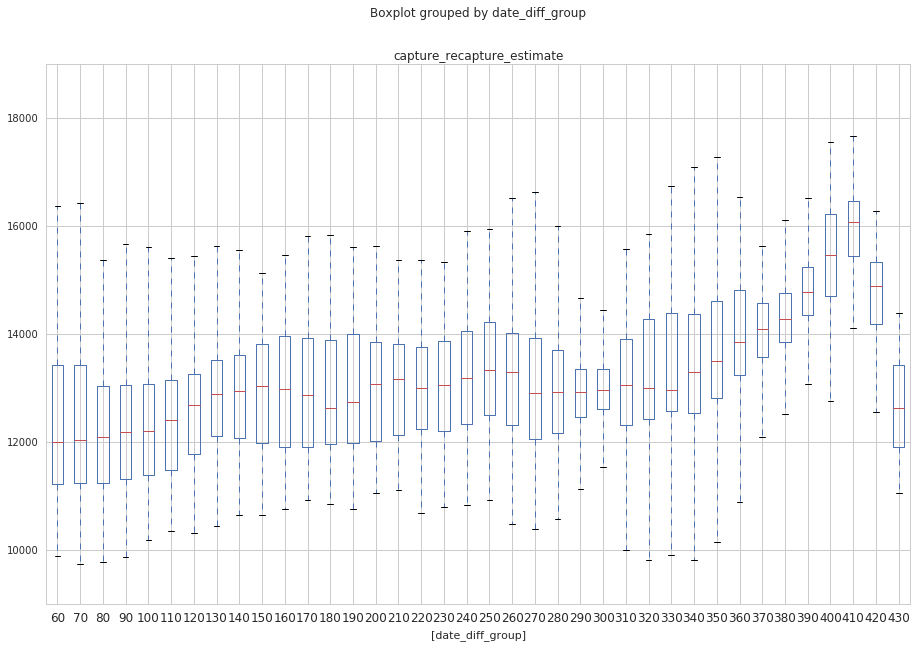

In [51]:
# Let's plot the same plot as above but using box plots, with the date_diff grouped in groups of 10 days
crs_estimates['date_diff_group'] = map(lambda x : int(round(x , -1)), crs_estimates['date_diff'])
crs_estimates[['date_diff_group','capture_recapture_estimate']].boxplot(by='date_diff_group', figsize=(15,10))

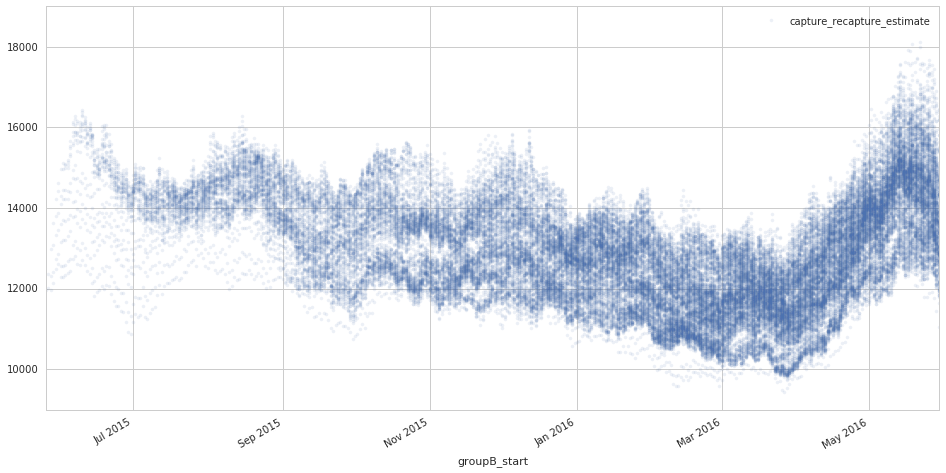

In [52]:
crs_estimates.plot(x='groupB_start', y='capture_recapture_estimate', alpha=0.1, style=".")

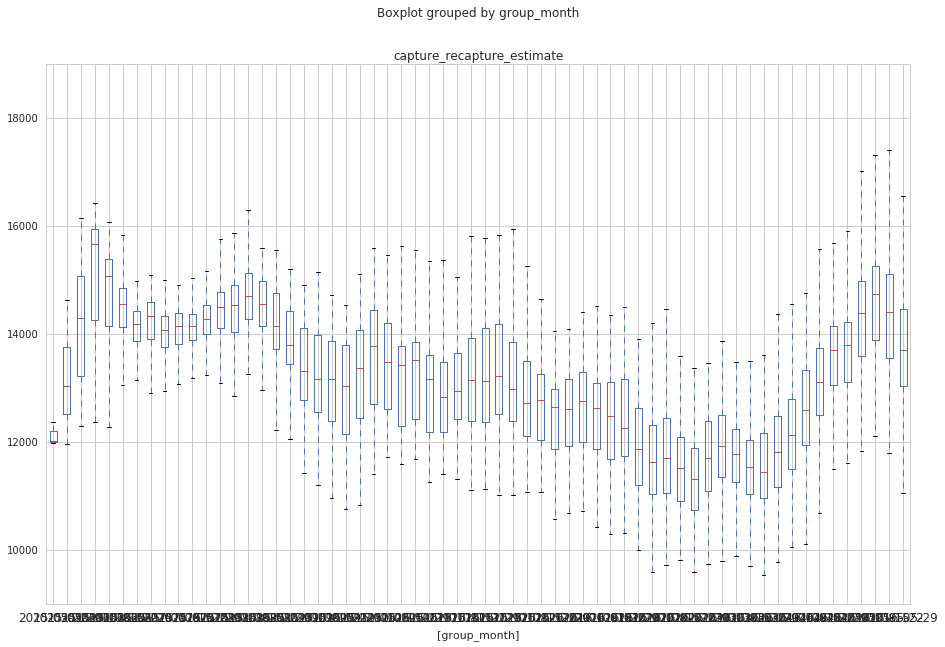

In [53]:
crs_estimates['group_month'] = map(lambda dt : dt.replace(hour=0, minute=0, second=0, microsecond=0, day=7*(dt.day/7)+1).date(), crs_estimates['groupB_start'])
crs_estimates[['group_month','capture_recapture_estimate']].boxplot(by='group_month', figsize=(15,10))

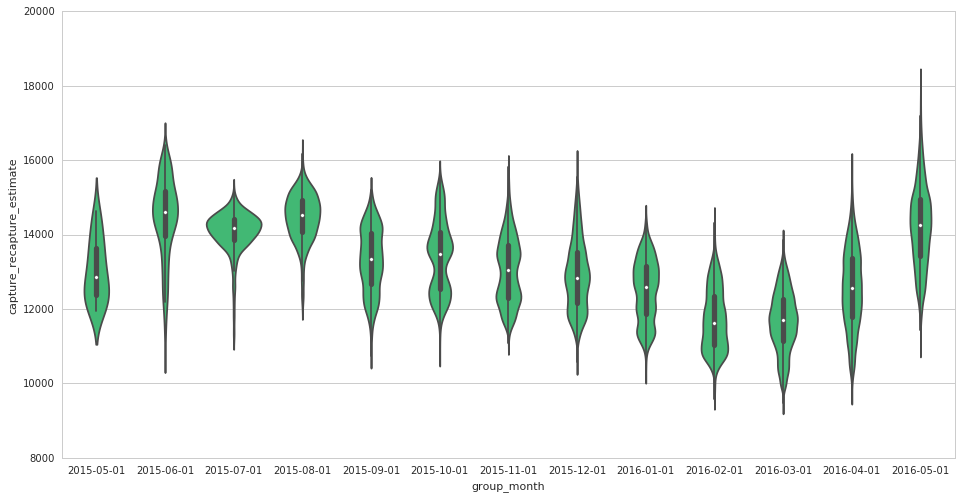

In [54]:
crs_estimates['group_month'] = map(lambda dt : dt.replace(hour=0, minute=0, second=0, microsecond=0, day=1).date(), crs_estimates['groupB_start'])
sns.violinplot(x='group_month', y='capture_recapture_estimate', data=crs_estimates.sort_values(by='group_month'), color="#2ecc71")

### Multiple Recapture Models

Our estimation process at this point relied on performing multiple two-sided comparisons and using the Linconln estimator.
Alternatively, we can use the Multiple Recapture Models introduced by Schnabel (1938) and Darroch (1958).





In [55]:
# How often do we see each worker?
df['worker_id'].value_counts()

52629358bb4b600cd895af4db743e93a    23
8d581e715b2ca964b55dc6ec3a02f7bc    23
cc15e2c74af011007361cef2b44fd33f    19
7227d93f54edef858df51213e2da65f9    19
a30d244141cb2f51e0803e79bc4bd147    17
f5897a5c69cd5c423a68fa0197ee0494    16
e02f2243f36f20070ad72bc75e9e59d7    16
c47662d0b3533a1aeacf29943d5a64f8    16
17f982691d3c6aebf9cb047d06dc2f12    16
7e7bbc4323d702dd2122a723fc7c297b    16
b1f852d1ef0dfceda899291ab02cc02a    15
b2eb9a410e941c1325823ecbceaef077    15
2eda5025dab05b703b648a58d849e166    15
96e1ca864c69ab8f35ae051ab9e7e7a8    15
1eea49ef4ad993a73014bd8f43a8064f    15
5b044cf509da1d8444b6f60c465240ef    15
98a18b3a53eb273babecb5ff88bee6dc    15
1e4879a728be7fae0d8181abaea1130c    15
49f024fa54e56dc620653bac007e88ca    15
a82df0f35d79cb92b986f092f88854b8    15
e5c4b601c2c07256dc55d8f631f73435    15
f04872a22a48af0c0c6bcdf02c4a8b59    15
b5dc717d9945a468fb14ae696303ef49    15
9209bd16839ff33192078642796f4bfe    15
d0affb3378f77c9500772f1d90efb7a1    15
bdd45646ab7d8efe4b4db763c

In [56]:
# Let's compute the frequency of captures
df['worker_id'].value_counts().value_counts()

1     17700
2      3654
3      1432
4       692
5       496
6       351
7       248
8       169
9       125
10      102
11       93
12       57
13       38
14       38
15       15
16        5
19        2
23        2
17        1
Name: worker_id, dtype: int64

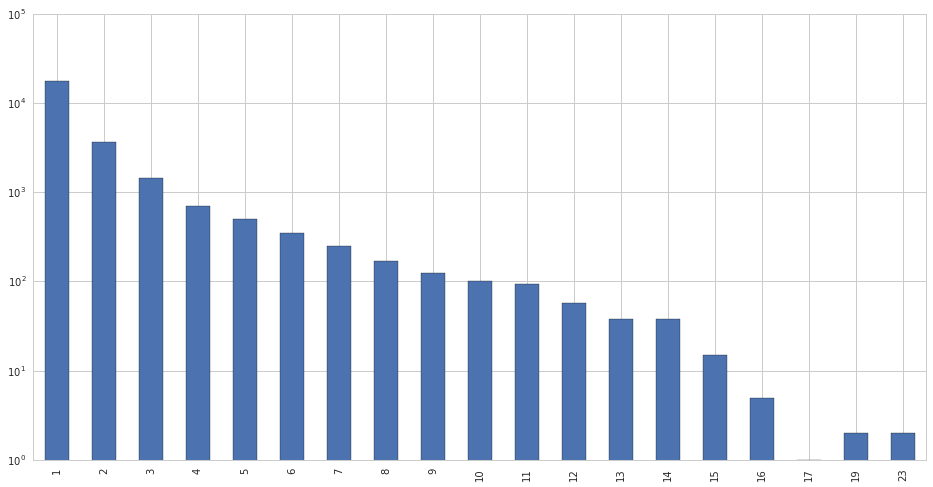

In [57]:
df['worker_id'].value_counts().value_counts().sort_index().plot.bar(logy=True)

In [58]:
df['worker_id'].value_counts().value_counts(normalize=True).sort_index()

1     0.701824
2     0.144885
3     0.056780
4     0.027439
5     0.019667
6     0.013918
7     0.009833
8     0.006701
9     0.004956
10    0.004044
11    0.003688
12    0.002260
13    0.001507
14    0.001507
15    0.000595
16    0.000198
17    0.000040
19    0.000079
23    0.000079
Name: worker_id, dtype: float64

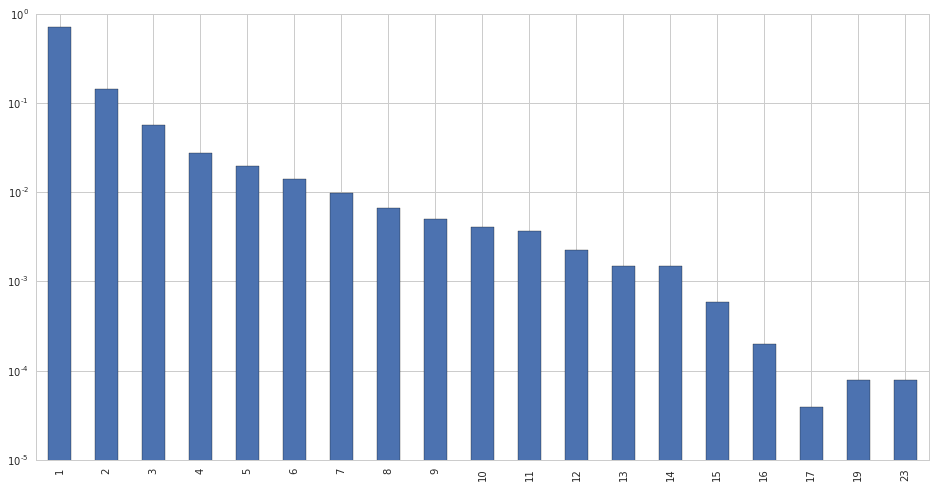

In [59]:
df['worker_id'].value_counts().value_counts(normalize=True).sort_index().plot.bar(logy=True)